## Setup

In [ ]:
# On Google Colab uncomment the following line to install PyTorch Lightning and the MedMNIST dataset
from google.colab import drive
drive.mount('/content/drive')
! pip install lightning medmnist

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import PIL

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST
from torch.utils.data.dataloader import default_collate



In [ ]:
# To save the interpolated signals and labels back to a .pt file:
# processed_data = {'signals': interpolated_signals, 'labels': labels}
# torch.save(processed_data, '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/data/ECG5000/train.pt')

In [ ]:
from scipy.interpolate import interp1d

# Function to load data from a .pt file and extract samples and labels
def load_data(data_path):
    data = torch.load(data_path)
    signals = data['samples'].numpy()
    labels = data['labels'].numpy()
    return signals, labels

# Function to interpolate signals to a target length and reshape into images
def interpolate_signals(signals, target_length):
    num_samples = signals.shape[0]
    N = int(np.sqrt(target_length))
    if N * N != target_length:
        raise ValueError("target_length must be a perfect square")

    images = np.zeros((num_samples, N, N), dtype=np.uint8)
    x_old = np.arange(signals.shape[2])
    x_new = np.linspace(0, signals.shape[2] - 1, num=target_length)

    for i in range(num_samples):
        f = interp1d(x_old, signals[i, 0, :], kind='linear')  # Assuming the signals are (num_samples, 1, length)
        interpolated_signal = f(x_new)
        normalized_signal = 255 * (interpolated_signal - np.min(interpolated_signal)) / np.ptp(interpolated_signal)
        images[i] = normalized_signal.reshape(N, N).astype(np.uint8)

    return images

# Paths to the .pt files
train_path = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/data/ElectricMotorFaults/train.pt'
val_path = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/data/ElectricMotorFaults/val.pt'
test_path = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/data/ElectricMotorFaults/test.pt'

# Load datasets
train_signals, train_labels = load_data(train_path)
val_signals, val_labels = load_data(val_path)
test_signals, test_labels = load_data(test_path)

# Define the new length for interpolation
new_length = 169  # This should be a perfect square, e.g., 13x13

# Interpolate signals
train_images = interpolate_signals(train_signals, new_length)
val_images = interpolate_signals(val_signals, new_length)
test_images = interpolate_signals(test_signals, new_length)

# Set the directory where you want to store the file
root_dir = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR'
file_name = 'ElectricMotorFaults_processed.npz'
file_path = os.path.join(root_dir, file_name)

# Save the data
np.savez_compressed(file_path,
                    train_images=train_images, train_labels=train_labels,
                    val_images=val_images, val_labels=val_labels,
                    test_images=test_images, test_labels=test_labels)

print(f"Data saved to {file_path}")

Data saved to /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/ElectricMotorFaults_processed.npz


In [ ]:
class SimCLRPneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split='train'):

        self.size = 8
        self.root = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR'

        npz_file = np.load(os.path.join(self.root, "HydraulicPump_processed.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train', 'val', 'test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        # Define the data augmentation pipeline
        # this method uses augmentation techniques of adding crops and minor rotations with a horizontal only flip for a first step and then adding noise to the two images for a second step
        self.augmentation_pipeline = transforms.Compose([
            transforms.RandomResizedCrop(size=self.size, scale=[0.2, 0.95], antialias = True),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=30, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomErasing(scale=[0.05, 0.20]),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        img = self.imgs[index]

        # Apply data augmentation (crop and resize)
        img = transforms.ToTensor()(Image.fromarray(img))
        img_view1 = self.augmentation_pipeline(img)
        img_view2 = self.augmentation_pipeline(img)

        return img_view1, img_view2

In [ ]:
class SimCLRPneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 128):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = SimCLRPneumoniaMNISTDataset(split='train')
        self.val_set = SimCLRPneumoniaMNISTDataset(split='val')
        self.test_set = SimCLRPneumoniaMNISTDataset(split='test')

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

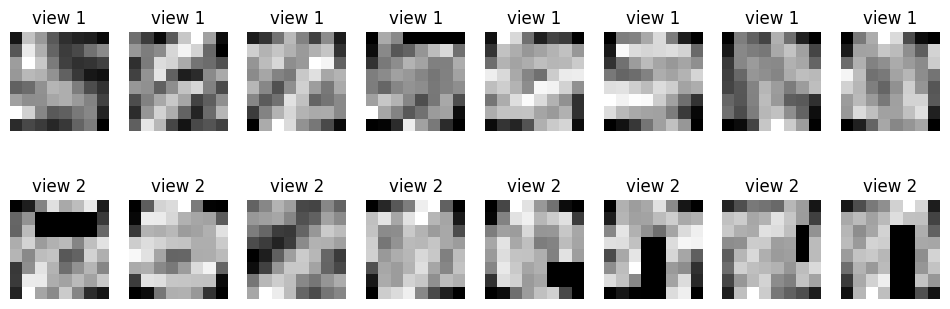

In [ ]:
# Initialise data module
datamodule = SimCLRPneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
view1, view2 = batch
f, ax = plt.subplots(2, 8, figsize=(12,4))
for i in range(8):
  ax[0,i].imshow(view1[i, 0], cmap='gray')
  ax[1,i].imshow(view2[i, 0], cmap='gray')
  ax[0,i].set_title('view 1')
  ax[1,i].set_title('view 2')
  ax[0, i].axis("off")
  ax[1, i].axis("off")

In [ ]:
def simclr_loss(embedding_view1, embedding_view2, tau=1.0):
    '''
    This function implements the SimCLR loss function as described in the original paper.
    See lecture notes for formulas.

    It takes as input the embeddings from both views and returns the loss value for that batch.
    Args:
        embedding_view1: torch tensor of shape [batch_size, embedding_dimension]
        embedding_view2: torch tensor of shape [batch_size, embedding_dimension]
        tau: temperature parameter (default: 1.0)
    Returns:
        loss: torch.tensor of shape 1
    '''

    # Step 1: normalize the embeddings
    normalized_embedding_view1 = F.normalize(embedding_view1, dim=1, p=2)
    normalized_embedding_view2 = F.normalize(embedding_view2, dim=1)

    # Step 2: gather all embeddings into one big vector of size [2 * N, feature_dim]
    z_all_views = torch.cat([normalized_embedding_view1, normalized_embedding_view2], dim=0)

    # Step 3: compute all possible similarities, should be a matrix of size [2 * N, 2 * N]
    # all_similarities[i,j] will be the similarity between z_all_views[i] and z_all_views[j].
    # Use the hint.
    all_similarities = torch.matmul(z_all_views, z_all_views.T)

    # Step 4: Here we want to return a mask of size[2 * N, 2* N] for which mask[i,j] = 1 if
    # z_all_views[i] and z_all_views[j] form a positive pair.
    # There should be exactely 2 * N non-zeros elements in this matrix.
    #mask_positive = torch.eye(z_all_views.shape[0], device=z_all_views.device)

    N = normalized_embedding_view1.shape[0]
    diagonal_mask = torch.eye(N)
    mask_positive = diagonal_mask.repeat(2, 2) - torch.eye(2*N)
    mask_positive = mask_positive.to(all_similarities.device)

    # Step 5: self-mask. For computing the denominator term in the loss function,
    # we need to sum over all possible similarities except the self-similarity.
    # Create a mask of shape [2*N, 2*N] that is 1 for all valid pairs and 0 for all self-pairs (i = j).
    #mask_self = 1 - torch.eye( z_all_views.shape[0], device=z_all_views.device)
    mask_self = torch.ones((2*N, 2*N)) - torch.eye(2*N)
    mask_self = mask_self.to(z_all_views.device)

    # Step 6: Computing all numerators for the loss function.
    # Should be vector of size [2 * N],
    # where element is exp(sim(i, j) / t) for each positive pair (i, j).
    # Re-use the computed quantities above.

    numerators = torch.exp(all_similarities / tau) * mask_positive
    numerators = numerators.sum(dim=1)

    # Step 7: Computing all denominators for the loss function.
    # Should be a vector of size [2 * N].
    # Where each element should be the sum of exp(sim(i,k)/tau) for all k != i.
    denominators = torch.exp(all_similarities / tau) * mask_self
    denominators = denominators.sum(dim=0)

    # Step 8: Return the final loss values, using the previously computing numerators and denominators.
    print(numerators / denominators)

    loss = -torch.log(numerators / denominators)

    return torch.mean(loss)


In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = models.resnet50(weights=None)

        # Modify conv1 to better suit small images
        self.net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Removing max pooling to preserve spatial dimensions
        self.net.maxpool = nn.Identity()

        # Removing the fully connected layer from ResNet
        del self.net.fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x = self.net.layer1(x)
        x = self.net.layer2(x)
        x = self.net.layer3(x)
        x = self.net.layer4(x)

        # Adjusting average pooling to accommodate smaller feature maps
        x = nn.AdaptiveAvgPool2d((1,1))(x)

        x = torch.flatten(x, 1)
        return x

class SimCLRModel(LightningModule):
    def __init__(self, learning_rate: float = 0.001):
        super().__init__()
        self.encoder = ImageEncoder()
        output_features = 2048  # This should match the final output of your ImageEncoder

        self.projector = nn.Sequential(
            nn.Linear(output_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
        )

        self.learning_rate = learning_rate
        self.save_hyperparameters()  # Saving hyperparameters

    def forward(self, x):
        embeddings = self.encoder(x)
        projections = self.projector(embeddings)
        return projections

    def process_batch(self, batch):
        # Extract embeddings from the encoder
        embeddings_view1 = self.encoder(batch[0])
        embeddings_view2 = self.encoder(batch[1])

        # Apply the projector to obtain the projected embeddings
        projections_view1 = self.projector(embeddings_view1)
        projections_view2 = self.projector(embeddings_view2)

        # Calculate SimCLR loss using the embeddings
        loss = simclr_loss(projections_view1, projections_view2, tau=0.5)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(torch.cat((batch[0][0:4, ...], batch[1][0:4, ...]), dim=0), nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)

In [ ]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY

data = SimCLRPneumoniaMNISTDataModule(batch_size=128)

model = SimCLRModel()

trainer = Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='simclr'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | encoder   | ImageEncoder | 23.5 M | train
1 | projector | Sequential   | 2.2 M  | train
---------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.914   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


tensor([0.0119, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0119,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0119, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0119, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0119, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0121], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

tensor([0.0042, 0.0038, 0.0043, 0.0034, 0.0037, 0.0044, 0.0045, 0.0037, 0.0041,
        0.0032, 0.0044, 0.0037, 0.0036, 0.0043, 0.0041, 0.0039, 0.0047, 0.0042,
        0.0037, 0.0041, 0.0044, 0.0044, 0.0047, 0.0039, 0.0043, 0.0044, 0.0046,
        0.0048, 0.0038, 0.0044, 0.0044, 0.0039, 0.0042, 0.0043, 0.0037, 0.0041,
        0.0035, 0.0044, 0.0045, 0.0042, 0.0037, 0.0041, 0.0044, 0.0044, 0.0032,
        0.0037, 0.0035, 0.0041, 0.0045, 0.0041, 0.0039, 0.0040, 0.0043, 0.0044,
        0.0043, 0.0045, 0.0037, 0.0039, 0.0038, 0.0045, 0.0036, 0.0040, 0.0038,
        0.0041, 0.0043, 0.0038, 0.0042, 0.0044, 0.0036, 0.0038, 0.0042, 0.0036,
        0.0042, 0.0038, 0.0038, 0.0036, 0.0041, 0.0039, 0.0044, 0.0047, 0.0043,
        0.0040, 0.0040, 0.0044, 0.0036, 0.0047, 0.0037, 0.0036, 0.0036, 0.0040,
        0.0045, 0.0043, 0.0043, 0.0046, 0.0045, 0.0038, 0.0031, 0.0047, 0.0042,
        0.0042, 0.0039, 0.0045, 0.0035, 0.0031, 0.0040, 0.0038, 0.0038, 0.0036,
        0.0040, 0.0040, 0.0044, 0.0038, 

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0121, 0.0119, 0.0119, 0.0120, 0.0122, 0.0121, 0.0123, 0.0119,
        0.0122, 0.0120, 0.0121, 0.0119, 0.0121, 0.0121, 0.0121, 0.0120, 0.0123,
        0.0120, 0.0122, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0122,
        0.0121, 0.0120, 0.0122, 0.0122, 0.0121, 0.0122, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0119, 0.0122, 0.0120, 0.0119, 0.0119, 0.0117,
        0.0120, 0.0120, 0.0122, 0.0121, 0.0123, 0.0120, 0.0122, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0122, 0.0119, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0122, 0.0121, 0.0121, 0.0123,
        0.0121, 0.0120, 0.0122, 0.0121, 0.0122, 0.0121, 0.0120, 0.0122, 0.0120,
        0.0117, 0.0121, 0.0119], device='cuda:0')
tensor([0.0044, 0.0041, 0.0041, 0.0044, 0.0039, 0.0037, 0.0039, 0.0043, 0.0049,
        0.0036, 0.0047, 0.0034, 0.0036, 0.0039, 0.0035, 0.0042, 0.0038, 0.0040,
        0.0039, 0.0040, 0.0041, 0.0044, 0.0042, 0.0042, 0.0045, 0.0040

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0121], device='cuda:0')
tensor([0.0040, 0.0039, 0.0041, 0.0041, 0.0041, 0.0040, 0.0039, 0.0041, 0.0043,
        0.0043, 0.0039, 0.0041, 0.0040, 0.0039, 0.0040, 0.0041, 0.0040, 0.0039,
        0.0042, 0.0041, 0.0040, 0.0042, 0.0042, 0.0040, 0.0040, 0.0040

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0120], device='cuda:0')
tensor([0.0041, 0.0042, 0.0041, 0.0043, 0.0041, 0.0042, 0.0041, 0.0041, 0.0041,
        0.0042, 0.0038, 0.0039, 0.0040, 0.0039, 0.0039, 0.0045, 0.0041, 0.0042,
        0.0041, 0.0042, 0.0039, 0.0041, 0.0041, 0.0038, 0.0040, 0.0039

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121], device='cuda:0')
tensor([0.0041, 0.0041, 0.0042, 0.0039, 0.0039, 0.0036, 0.0041, 0.0040, 0.0042,
        0.0035, 0.0041, 0.0038, 0.0042, 0.0040, 0.0040, 0.0040, 0.0040, 0.0042,
        0.0039, 0.0040, 0.0036, 0.0042, 0.0040, 0.0037, 0.0040, 0.0040

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0120, 0.0121], device='cuda:0')
tensor([0.0041, 0.0040, 0.0039, 0.0040, 0.0042, 0.0041, 0.0041, 0.0040, 0.0040,
        0.0039, 0.0040, 0.0041, 0.0040, 0.0041, 0.0040, 0.0041, 0.0041, 0.0041,
        0.0041, 0.0039, 0.0041, 0.0040, 0.0040, 0.0042, 0.0041, 0.0040

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0120], device='cuda:0')
tensor([0.0041, 0.0041, 0.0041, 0.0040, 0.0038, 0.0039, 0.0040, 0.0040, 0.0041,
        0.0039, 0.0041, 0.0041, 0.0041, 0.0042, 0.0041, 0.0041, 0.0040, 0.0042,
        0.0040, 0.0039, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120], device='cuda:0')
tensor([0.0041, 0.0040, 0.0041, 0.0042, 0.0041, 0.0042, 0.0041, 0.0040, 0.0040,
        0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0040,
        0.0041, 0.0041, 0.0039, 0.0040, 0.0041, 0.0040, 0.0039, 0.0039

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121], device='cuda:0')
tensor([0.0041, 0.0040, 0.0041, 0.0038, 0.0042, 0.0041, 0.0040, 0.0041, 0.0040,
        0.0041, 0.0040, 0.0041, 0.0040, 0.0041, 0.0041, 0.0040, 0.0040, 0.0039,
        0.0041, 0.0040, 0.0040, 0.0040, 0.0041, 0.0041, 0.0038, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121], device='cuda:0')
tensor([0.0039, 0.0041, 0.0040, 0.0039, 0.0041, 0.0040, 0.0041, 0.0039, 0.0041,
        0.0041, 0.0041, 0.0042, 0.0041, 0.0038, 0.0040, 0.0041, 0.0042, 0.0040,
        0.0041, 0.0041, 0.0041, 0.0040, 0.0038, 0.0040, 0.0041, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120], device='cuda:0')
tensor([0.0041, 0.0040, 0.0041, 0.0039, 0.0040, 0.0041, 0.0042, 0.0041, 0.0041,
        0.0040, 0.0040, 0.0041, 0.0041, 0.0040, 0.0040, 0.0040, 0.0039, 0.0039,
        0.0040, 0.0041, 0.0039, 0.0041, 0.0041, 0.0037, 0.0037, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0119, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0119, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121], device='cuda:0')
tensor([0.0040, 0.0040, 0.0041, 0.0041, 0.0040, 0.0041, 0.0042, 0.0041, 0.0037,
        0.0040, 0.0041, 0.0040, 0.0041, 0.0040, 0.0040, 0.0042, 0.0039, 0.0041,
        0.0041, 0.0041, 0.0042, 0.0038, 0.0041, 0.0040, 0.0040, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0120, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0119, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0120], device='cuda:0')
tensor([0.0040, 0.0040, 0.0041, 0.0042, 0.0041, 0.0040, 0.0041, 0.0039, 0.0039,
        0.0040, 0.0039, 0.0042, 0.0043, 0.0041, 0.0041, 0.0041, 0.0041, 0.0039,
        0.0042, 0.0040, 0.0040, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0119, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0119, 0.0121, 0.0121, 0.0121, 0.0119, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0119,
        0.0120, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121], device='cuda:0')
tensor([0.0037, 0.0041, 0.0041, 0.0040, 0.0041, 0.0039, 0.0042, 0.0041, 0.0040,
        0.0041, 0.0041, 0.0042, 0.0041, 0.0041, 0.0038, 0.0040, 0.0042, 0.0041,
        0.0038, 0.0039, 0.0043, 0.0040, 0.0040, 0.0041, 0.0042, 0.0038

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0119, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0119, 0.0121, 0.0121,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0119, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121], device='cuda:0')
tensor([0.0037, 0.0041, 0.0041, 0.0040, 0.0041, 0.0039, 0.0042, 0.0037, 0.0042,
        0.0036, 0.0041, 0.0042, 0.0041, 0.0039, 0.0040, 0.0040, 0.0041, 0.0040,
        0.0041, 0.0043, 0.0041, 0.0039, 0.0039, 0.0042, 0.0041, 0.0040

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0120, 0.0116, 0.0121, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0119, 0.0120, 0.0120,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0119, 0.0120, 0.0121, 0.0120, 0.0121,
        0.0119, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0122,
        0.0120, 0.0118, 0.0121, 0.0120, 0.0121, 0.0120, 0.0119, 0.0121, 0.0121,
        0.0120, 0.0121, 0.0121], device='cuda:0')
tensor([0.0044, 0.0039, 0.0039, 0.0042, 0.0040, 0.0038, 0.0043, 0.0041, 0.0042,
        0.0037, 0.0040, 0.0039, 0.0042, 0.0043, 0.0040, 0.0041, 0.0041, 0.0039,
        0.0037, 0.0041, 0.0040, 0.0041, 0.0041, 0.0044, 0.0042, 0.0038

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0120, 0.0121,
        0.0120, 0.0118, 0.0122, 0.0120, 0.0121, 0.0119, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0122, 0.0121, 0.0121, 0.0116, 0.0120, 0.0120,
        0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0121,
        0.0121, 0.0119, 0.0121, 0.0121, 0.0120, 0.0121, 0.0119, 0.0118, 0.0123,
        0.0119, 0.0121, 0.0120, 0.0120, 0.0121, 0.0120, 0.0121, 0.0121, 0.0120,
        0.0122, 0.0121, 0.0121, 0.0121, 0.0122, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121,
        0.0121, 0.0121, 0.0121], device='cuda:0')
tensor([0.0042, 0.0041, 0.0040, 0.0043, 0.0040, 0.0041, 0.0041, 0.0041, 0.0037,
        0.0041, 0.0044, 0.0035, 0.0041, 0.0042, 0.0040, 0.0037, 0.0041, 0.0038,
        0.0041, 0.0043, 0.0044, 0.0042, 0.0039, 0.0040, 0.0039, 0.0039

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0120, 0.0121, 0.0119, 0.0122, 0.0120, 0.0119, 0.0117,
        0.0122, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0121, 0.0121, 0.0121,
        0.0122, 0.0121, 0.0120, 0.0121, 0.0119, 0.0121, 0.0122, 0.0121, 0.0120,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0122, 0.0121, 0.0120, 0.0122, 0.0126,
        0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0119, 0.0121, 0.0121, 0.0120,
        0.0121, 0.0120, 0.0122, 0.0120, 0.0119, 0.0119, 0.0122, 0.0121, 0.0121,
        0.0121, 0.0119, 0.0121, 0.0122, 0.0122, 0.0120, 0.0121, 0.0122, 0.0118,
        0.0121, 0.0120, 0.0122, 0.0123, 0.0121, 0.0119, 0.0122, 0.0120, 0.0121,
        0.0121, 0.0120, 0.0121, 0.0121, 0.0122, 0.0121, 0.0120, 0.0121, 0.0120,
        0.0120, 0.0121, 0.0120], device='cuda:0')
tensor([0.0040, 0.0042, 0.0040, 0.0042, 0.0044, 0.0040, 0.0041, 0.0042, 0.0042,
        0.0038, 0.0041, 0.0042, 0.0041, 0.0041, 0.0042, 0.0036, 0.0042, 0.0041,
        0.0041, 0.0041, 0.0041, 0.0041, 0.0040, 0.0042, 0.0039, 0.0038

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0121, 0.0121, 0.0122, 0.0120, 0.0121, 0.0122, 0.0119, 0.0121, 0.0122,
        0.0122, 0.0120, 0.0123, 0.0121, 0.0121, 0.0121, 0.0120, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0120, 0.0119, 0.0122, 0.0121, 0.0120, 0.0119, 0.0117,
        0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0117, 0.0121,
        0.0119, 0.0122, 0.0121, 0.0122, 0.0121, 0.0122, 0.0122, 0.0121, 0.0120,
        0.0121, 0.0116, 0.0122, 0.0120, 0.0121, 0.0122, 0.0122, 0.0120, 0.0122,
        0.0122, 0.0120, 0.0125, 0.0118, 0.0119, 0.0120, 0.0121, 0.0117, 0.0121,
        0.0121, 0.0122, 0.0121, 0.0120, 0.0119, 0.0116, 0.0117, 0.0123, 0.0120,
        0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0121, 0.0122, 0.0119,
        0.0122, 0.0121, 0.0121], device='cuda:0')
tensor([0.0041, 0.0041, 0.0041, 0.0039, 0.0041, 0.0041, 0.0044, 0.0042, 0.0041,
        0.0041, 0.0042, 0.0040, 0.0041, 0.0041, 0.0041, 0.0037, 0.0041, 0.0039,
        0.0040, 0.0034, 0.0042, 0.0041, 0.0041, 0.0039, 0.0040, 0.0043

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0123, 0.0120, 0.0120, 0.0119, 0.0122, 0.0121, 0.0120, 0.0120, 0.0122,
        0.0118, 0.0118, 0.0121, 0.0122, 0.0120, 0.0122, 0.0122, 0.0122, 0.0121,
        0.0122, 0.0122, 0.0121, 0.0120, 0.0123, 0.0123, 0.0122, 0.0122, 0.0121,
        0.0121, 0.0121, 0.0115, 0.0119, 0.0122, 0.0121, 0.0111, 0.0122, 0.0114,
        0.0122, 0.0122, 0.0122, 0.0130, 0.0122, 0.0121, 0.0121, 0.0120, 0.0120,
        0.0119, 0.0122, 0.0122, 0.0121, 0.0122, 0.0122, 0.0118, 0.0119, 0.0120,
        0.0120, 0.0118, 0.0122, 0.0122, 0.0121, 0.0122, 0.0123, 0.0121, 0.0121,
        0.0122, 0.0122, 0.0122, 0.0121, 0.0122, 0.0120, 0.0121, 0.0120, 0.0118,
        0.0120, 0.0122, 0.0122, 0.0107, 0.0121, 0.0118, 0.0123, 0.0122, 0.0121,
        0.0136, 0.0121, 0.0122], device='cuda:0')
tensor([0.0041, 0.0038, 0.0039, 0.0040, 0.0042, 0.0040, 0.0041, 0.0040, 0.0042,
        0.0041, 0.0040, 0.0040, 0.0041, 0.0043, 0.0041, 0.0041, 0.0040, 0.0041,
        0.0040, 0.0039, 0.0038, 0.0042, 0.0042, 0.0041, 0.0042, 0.0041

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


tensor([0.0114, 0.0120, 0.0121, 0.0122, 0.0119, 0.0118, 0.0122, 0.0116, 0.0122,
        0.0121, 0.0122, 0.0115, 0.0128, 0.0121, 0.0124, 0.0120, 0.0119, 0.0122,
        0.0119, 0.0122, 0.0121, 0.0118, 0.0122, 0.0122, 0.0123, 0.0121, 0.0121,
        0.0124, 0.0123, 0.0121, 0.0112, 0.0120, 0.0119, 0.0122, 0.0121, 0.0117,
        0.0122, 0.0121, 0.0123, 0.0114, 0.0119, 0.0104, 0.0117, 0.0119, 0.0122,
        0.0121, 0.0118, 0.0118, 0.0123, 0.0117, 0.0123, 0.0121, 0.0120, 0.0116,
        0.0127, 0.0121, 0.0124, 0.0121, 0.0119, 0.0122, 0.0120, 0.0123, 0.0121,
        0.0117, 0.0121, 0.0123, 0.0122, 0.0121, 0.0122, 0.0124, 0.0122, 0.0120,
        0.0116, 0.0119, 0.0121, 0.0121, 0.0122, 0.0118, 0.0121, 0.0122, 0.0123,
        0.0113, 0.0120, 0.0114], device='cuda:0')


In [ ]:
from torchmetrics import Accuracy, F1Score, Precision, Recall

class LinearProbeDataset(MedMNIST):
    def __init__(self, split='train'):

        self.size = 8
        self.root = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR'

        npz_file = np.load(os.path.join(self.root, "HydraulicPump_processed.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train', 'val', 'test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']


    def __getitem__(self, index):
        x = self.imgs[index]
        x = np.expand_dims(x, axis=0)  # Adding channel dimension
        x = torch.from_numpy(x).float()
        y = torch.tensor(self.labels[index], dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.imgs)

class LinearProbeDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 128):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_set = LinearProbeDataset(split='train')
        self.val_set = LinearProbeDataset(split='val')
        self.test_set = LinearProbeDataset(split='test')

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

class LinearProbeClassifier(LightningModule):
    def __init__(self, encoder, num_classes, learning_rate=0.001):
        super().__init__()
        # Only pass serializable hyperparameters to `save_hyperparameters`
        self.save_hyperparameters('num_classes', 'learning_rate')

        self.encoder = encoder
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.classifier = nn.Linear(128, num_classes)  # Assumes output features from encoder are 2048
        self.accuracy = Accuracy(num_classes=num_classes, average='weighted', task='multiclass')
        self.f1_score = F1Score(num_classes=num_classes, average='weighted', task='multiclass')
        self.precision = Precision(num_classes=num_classes, average='weighted', task='multiclass')
        self.recall = Recall(num_classes=num_classes, average='weighted', task='multiclass')

        # Freeze the encoder, comment these two lines for fully supervised training
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.save_hyperparameters()

    def forward(self, x):
        self.encoder.eval()
        embeddings = self.encoder(x)
        return self.classifier(embeddings)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy(preds, y), prog_bar=True)
        self.log('train_f1', self.f1_score(preds, y), prog_bar=True)
        self.log('train_precision', self.precision(preds, y), prog_bar=True)
        self.log('train_recall', self.recall(preds, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(preds, y), prog_bar=True)
        self.log('val_f1', self.f1_score(preds, y), prog_bar=True)
        self.log('val_precision', self.precision(preds, y), prog_bar=True)
        self.log('val_recall', self.recall(preds, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # This method can be very similar to validation_step
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(preds, y))
        self.log('test_f1', self.f1_score(preds, y))
        self.log('test_precision', self.precision(preds, y))
        self.log('test_recall', self.recall(preds, y))
        return {"test_loss": loss}
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)

# Example of creating an instance of the classifier
classifier = LinearProbeClassifier(SimCLRModel(), num_classes=3)  # Specify correct number of classes

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Setting up callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',    # Metric to monitor
    dirpath='/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/logs',   # Path where models will be saved
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,          # Save the top 3 models
    mode='min'             # Save models with the minimum val_loss observed
)

progress_bar = TQDMProgressBar(refresh_rate=10)  # Refresh every 10 steps

# Creating the Trainer
trainer = Trainer(
    max_epochs=20,
    accelerator='auto',  # Automatically use GPU if available, otherwise CPU
    devices='auto',      # Automatically determine the number of GPUs available, or use CPU if none
    callbacks=[checkpoint_callback, progress_bar],
    logger=False
)

data = LinearProbeDataModule(batch_size=32)

trainer.fit(model=classifier, datamodule=data)

print(f'Evaluating model on the validation set.')
trainer.validate(model=classifier, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

print(f'Evaluating model on the test set.')
trainer.test(model=classifier, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | SimCLRModel         | 25.7 M | train
1 | classifier | Linear              | 387    | train
2 | accuracy   | MulticlassAccuracy  | 0      | train
3 | f1_score   | MulticlassF1Score   | 0      | train
4 | precision  | MulticlassPrecision | 0      | train
5 | recall     | MulticlassRecall    | 0      | train
-----------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.916   Total estimated model params size (

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Evaluating model on the validation set.


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/logs/model-epoch=18-val_loss=1.99.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/logs/model-epoch=18-val_loss=1.99.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.4047619104385376     │
│          val_f1           │    0.3790627419948578     │
│         val_loss          │     1.987418532371521     │
│       val_precision       │    0.3943723142147064     │
│        val_recall         │    0.4047619104385376     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/logs/model-epoch=18-val_loss=1.99.ckpt


Evaluating model on the test set.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/SimCLR/logs/model-epoch=18-val_loss=1.99.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.380952388048172     │
│          test_f1          │    0.3522186279296875     │
│         test_loss         │    2.3179101943969727     │
│      test_precision       │    0.3438909947872162     │
│        test_recall        │     0.380952388048172     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.3179101943969727,
  'test_acc': 0.380952388048172,
  'test_f1': 0.3522186279296875,
  'test_precision': 0.3438909947872162,
  'test_recall': 0.380952388048172}]